In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
from nltk import word_tokenize
import numpy as np
import re
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from tqdm.auto import tqdm, trange

In [30]:
cluster = LocalCluster(n_workers=16)
client = Client(cluster)

In [3]:
candidate_sentences = pd.read_csv("candidate_sentences-gpt2-annotated.csv", index_col=0)

In [4]:
# Drop manually excluded
candidate_sentences = candidate_sentences[candidate_sentences["JG exclude"].isna()]

In [5]:
# only retain words+sentences which have >= 1 sentence for high and low labels
print(candidate_sentences.groupby("target_word").ngroups)
candidate_sentences = candidate_sentences.groupby(["target_word"]).filter(lambda x: x["label"].nunique() == 2)
print(candidate_sentences.groupby("target_word").ngroups)

129
106


In [6]:
candidate_sentences["sentence_length"] = candidate_sentences.sentence.apply(lambda x: len([x for x in word_tokenize(x) if not re.match(r'\W+', x)]))

In [7]:
words = pd.read_csv("adopted_df_blocks_withBalancedUnion.csv").set_index("word_us")

In [8]:
# Retain only those covered by the sentences
print(len(words))
words = words.loc[candidate_sentences["target_word"].unique()]
print(len(words))
words

132
106


,word_length,ortho_n_dens_s,ortho_n_freq_s_m,ortho_n_freq_s_sd,ortho_upoint,old20_m,old20_sd,sum_bigram,n_phon,n_syll,...,snd_arc,aff_val_m,aff_val_sd,aff_arou_m,aff_arou_sd,aff_dom_m,aff_dom_sd,Unnamed: 30,COND,block
word_us,,,,,,,,,,,,,,,,,,,,,
angle,5,1,2.612784,NaN,6,1.65,0.489360,0.022517,5,2,...,0.611150,4.55,1.28,3.22,2.24,5.27,1.83,NaN,O+P-,4
area,4,3,1.414313,0.874882,4,1.75,0.444262,0.035175,4,3,...,0.677775,5.56,1.29,2.19,1.60,5.06,1.76,NaN,O-P-,1
baby,4,1,3.258877,NaN,5,1.90,0.307794,0.015180,4,2,...,0.647788,6.67,2.36,4.97,2.65,4.94,2.87,NaN,O-P-,4
bait,4,4,2.487701,1.650007,4,1.70,0.470162,0.026305,3,1,...,0.514355,4.00,1.83,3.50,2.02,5.95,2.32,NaN,O-P+,2
beach,5,7,2.384041,0.929191,6,1.50,0.512989,0.047662,3,1,...,0.658304,7.21,1.51,5.10,2.23,5.70,2.33,NaN,O+P+,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind,4,11,3.039627,1.145753,5,1.35,0.489360,0.032707,4,1,...,0.651939,5.67,2.22,3.70,2.47,4.50,2.36,NaN,O+P+,3
wish,4,7,2.958385,1.461394,5,1.60,0.502625,0.029318,3,1,...,0.637178,7.14,1.77,3.38,2.33,6.50,2.33,NaN,O+P+,4
wood,4,7,3.371046,1.074693,5,1.50,0.512989,0.019520,3,1,...,0.667203,5.82,1.47,3.50,1.70,6.37,2.71,NaN,O+P+,3


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


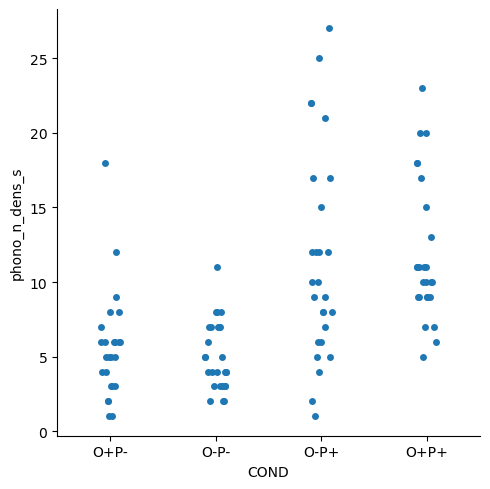

In [9]:
# Drop words which are outliers for their neighborhood condition
sns.catplot(data=words, x="COND", y="phono_n_dens_s")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


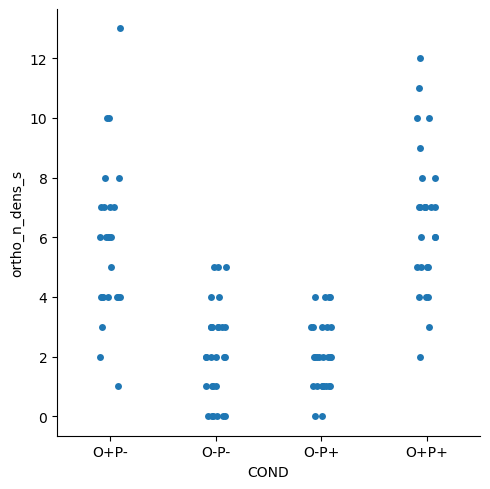

In [10]:
sns.catplot(data=words, x="COND", y="ortho_n_dens_s")

In [11]:
# drop low-PND outliers in P+ conditions
words = words.loc[~words.index.isin(words[(words.COND == "O-P+") & (words.phono_n_dens_s < 5)].index)]

In [18]:
# drop low-OND outliers in O+ condition
words = words.loc[~words.index.isin(words[(words.COND == "O+P-") & (words.ortho_n_dens_s <= 2)].index)]

In [25]:
# drop high-PND outliers in P- conditions
words = words.loc[~words.index.isin(words[(words.COND == "O+P-") & (words.phono_n_dens_s > 10)].index)]
words = words.loc[~words.index.isin(words[(words.COND == "O-P-") & (words.phono_n_dens_s > 10)].index)]

## Rejection sampling method

In [26]:
merged = pd.merge(candidate_sentences, words, left_on="target_word", right_on="word_us")
merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())

/tmp/ipykernel_3253868/1251679934.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())


COND
O+P+    26
O+P-    21
O-P+    24
O-P-    27
dtype: int64

In [28]:
# target number of words per condition (OND*PND*surprisal)
word_sample_size = 16

# we want to maximize differences in these variables between conditions
max_variables = ["surprisal", "ortho_n_dens_s", "phono_n_dens_s"]
# we want to minimize differences in these variables between conditions
min_variables = ["word_length", "n_phon", "n_syll", "sum_bigram", "sum_biphone",
                 "lgsubtlwf", "concrete_m", "aff_val_m", "aff_arou_m",
                 "sentence_length", "entropy"]

def get_sample():
    s_words = words.groupby("COND").sample(20, replace=False)
    s_sentences = pd.merge(candidate_sentences, s_words, left_on="target_word", right_on="word_us").groupby(["target_word", "label"]).sample(1)

    s_melted = s_sentences.reset_index().melt(
        id_vars=["target_word", "label", "COND", "sentence"],
        value_vars=["surprisal", "entropy", "word_length", "ortho_n_dens_s",
                    "ortho_n_freq_s_m", "ortho_upoint", "old20_m",
                    "sum_bigram", "n_phon", "n_syll", "phono_n_dens_s",
                    "phono_n_freq_s_m", "phono_upoint", "pld20_m",
                    "sum_biphone", "lgsubtlwf", "concrete_m",
                    "aff_val_m", "aff_arou_m", "sentence_length"])
    s_melted["our_cond"] = s_melted.COND + " " + s_melted.label

    return s_words, s_sentences, s_melted

def get_stats(melted_df):
    return melted_df.groupby("variable").apply(lambda x: pd.Series(st.f_oneway(*[x.loc[x.our_cond == cond, "value"] for cond in x.our_cond.unique()]), index=["F", "p"]), include_groups=False)

def objective(sentence_df, melted_df, alpha=0.01, verbose=False):
    # First ensure that the relevant condition t-tests pass
    # we expect differences in the relevant target variables between these conds
    target_positive_tests = [("ortho_n_dens_s", "COND", "O+P+", "O-P+"),
                             ("ortho_n_dens_s", "COND", "O+P-", "O-P-"),
                             ("ortho_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("phono_n_dens_s", "COND", "O+P+", "O+P-"),
                             ("phono_n_dens_s", "COND", "O-P+", "O-P-"),
                             ("phono_n_dens_s", "COND", "O-P-", "O+P+"),
                             ("surprisal", "label", "high", "low")]
    for var, grouping_variable, group1, group2 in target_positive_tests:
        sentence_df_ = sentence_df.set_index(grouping_variable)
        ttest_t, ttest_p = st.ttest_ind(sentence_df_.loc[group1, var], sentence_df_.loc[group2, var])
        if ttest_p > alpha:
            if verbose:
                print(f"failed positive t-test for {var} between {group1} and {group2}")
            return -np.inf
            
    # we expect no significant differences in these variables between these conds
    target_null_tests = [("ortho_n_dens_s", "COND", "O+P+", "O+P-"),
                         ("ortho_n_dens_s", "COND", "O-P+", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P-", "O-P-"),
                         ("phono_n_dens_s", "COND", "O+P+", "O-P+"),]
    for var, grouping_variable, group1, group2 in target_null_tests:
        sentence_df_ = sentence_df.set_index(grouping_variable)
        ttest_t, ttest_p = st.ttest_ind(sentence_df_.loc[group1, var], sentence_df_.loc[group2, var])
        if ttest_p < alpha:
            if verbose:
                print(f"failed null t-test for {var} between {group1} and {group2}")
            return -np.inf

    # F-test
    results = get_stats(melted_df)

    # max_p = results.loc[max_variables, "p"].min()
    min_p = results.loc[min_variables, "p"].min()

    # it's easy to maximize the max variables -- let's focus on the min variables
    # return max_diff - min_diff
    
    return min_p

In [29]:
@delayed
def sample_and_evaluate():
    s_words, s_sentences, s_melted = get_sample()
    obj = objective(s_sentences, s_melted)
    return obj, (s_words, s_sentences, s_melted)

In [31]:
# Create a list of delayed evaluation tasks
tasks = [sample_and_evaluate() for i in range(50000)]

# Compute all tasks in parallel
with ProgressBar():
    results = compute(*tasks, scheduler="processes")

# Extract the best sample and objective value
best_objective = float("-inf")
best_sample = None

for i, (obj, sample) in enumerate(results):
    if obj > best_objective:
        print(i, obj)
        best_objective = obj
        best_sample = sample

/home/jgauthier/u/transformers/lib/python3.10/site-packages/dask/base.py:1487: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


[#################                       ] | 44% Completed | 204.41 s

In [17]:
# sample id is a hash of the current timestamp
from time import time
from hashlib import sha1
sample_id = sha1(str(int(time())).encode()).hexdigest()[:8]
print(sample_id)

s_words, s_sentences, s_melted = best_sample
s_words.to_csv(f"{sample_id}-words.csv")
s_sentences.to_csv(f"{sample_id}-sentences.csv")
s_melted.to_csv(f"{sample_id}-melted.csv")

s_stats = get_stats(s_melted).sort_values("p")
s_stats.to_csv(f"{sample_id}-stats.csv")

3552a52c


In [18]:
s_stats

,F,p
variable,,
surprisal,494.585261,3.725909e-101
old20_m,36.860484,9.062314e-30
ortho_n_dens_s,25.314370,1.091136e-22
pld20_m,17.322356,9.582189e-17
phono_n_dens_s,12.849544,6.488425e-13
phono_n_freq_s_m,5.745701,6.485744e-06
word_length,2.304868,2.921355e-02
sum_bigram,2.258481,3.252368e-02
n_phon,2.089708,4.785239e-02


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Target manipulations')

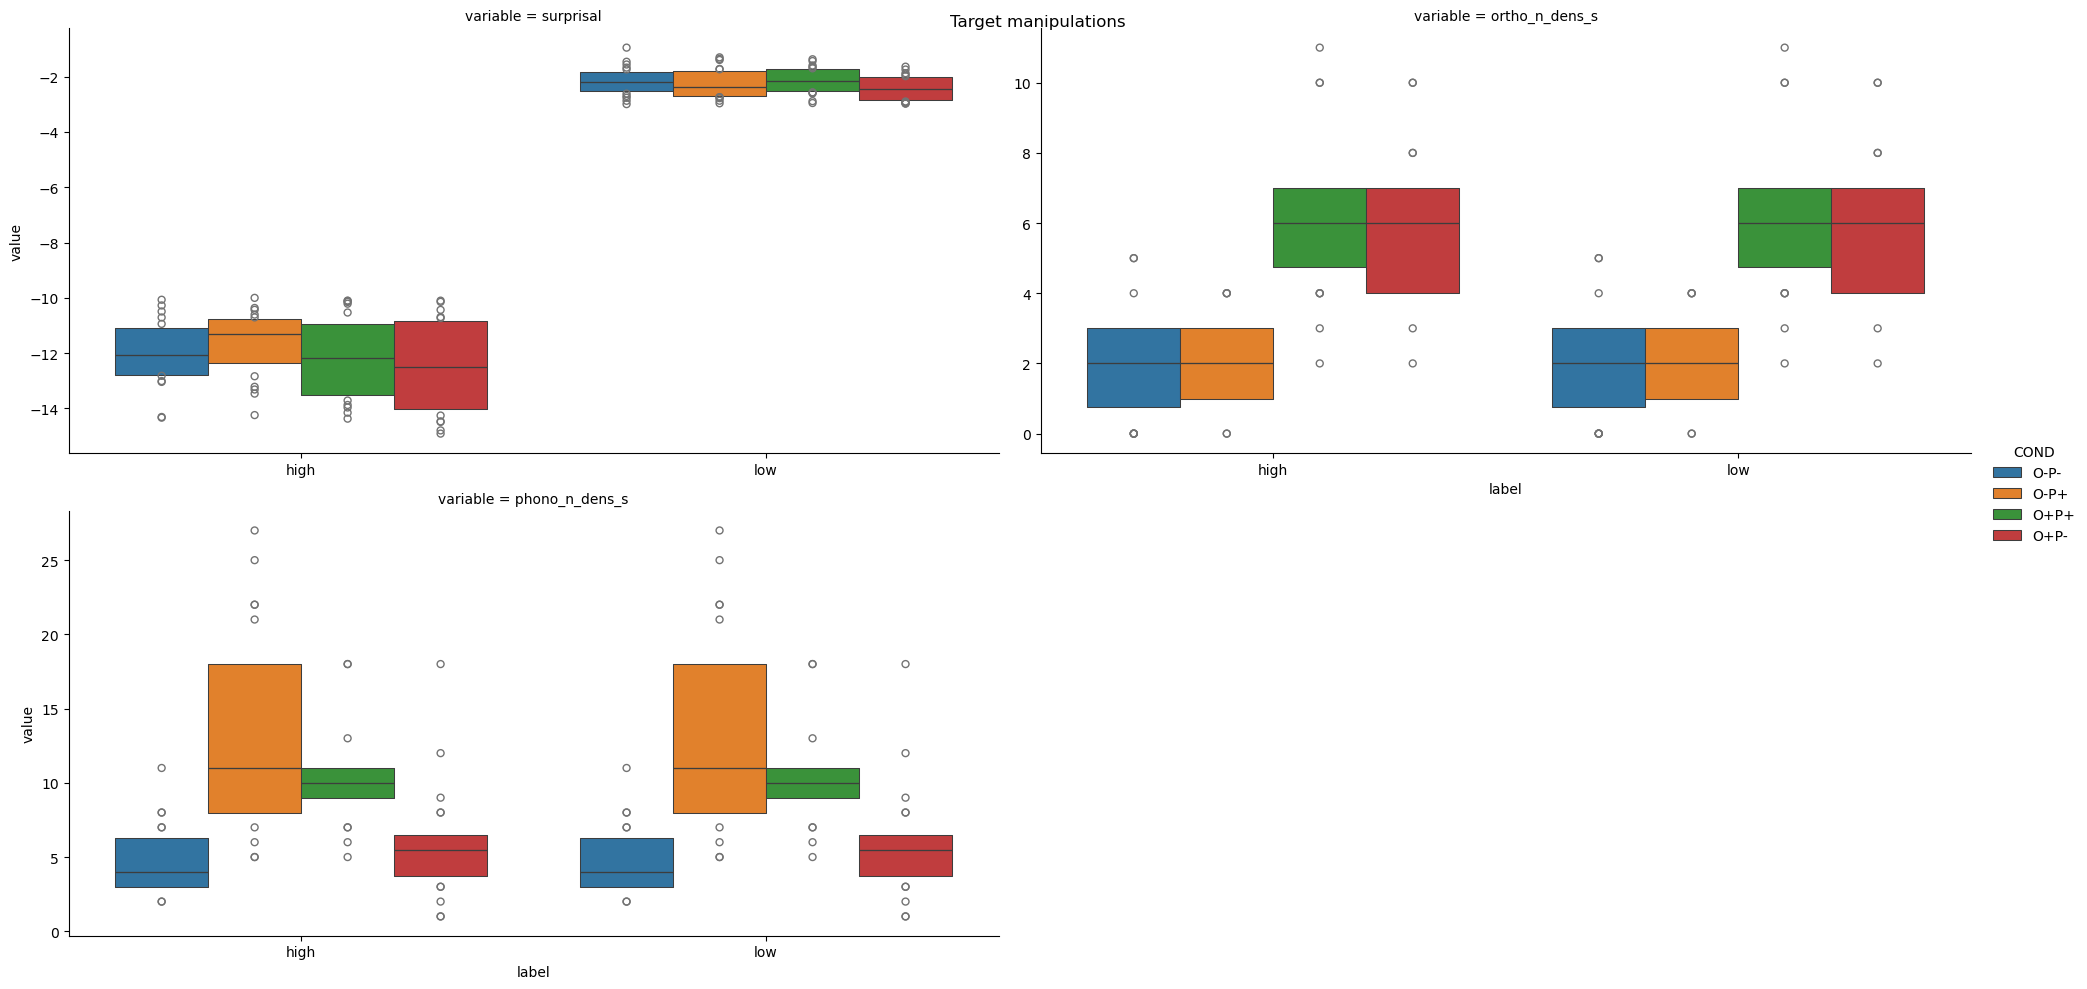

In [19]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(max_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Aim to match between conditions')

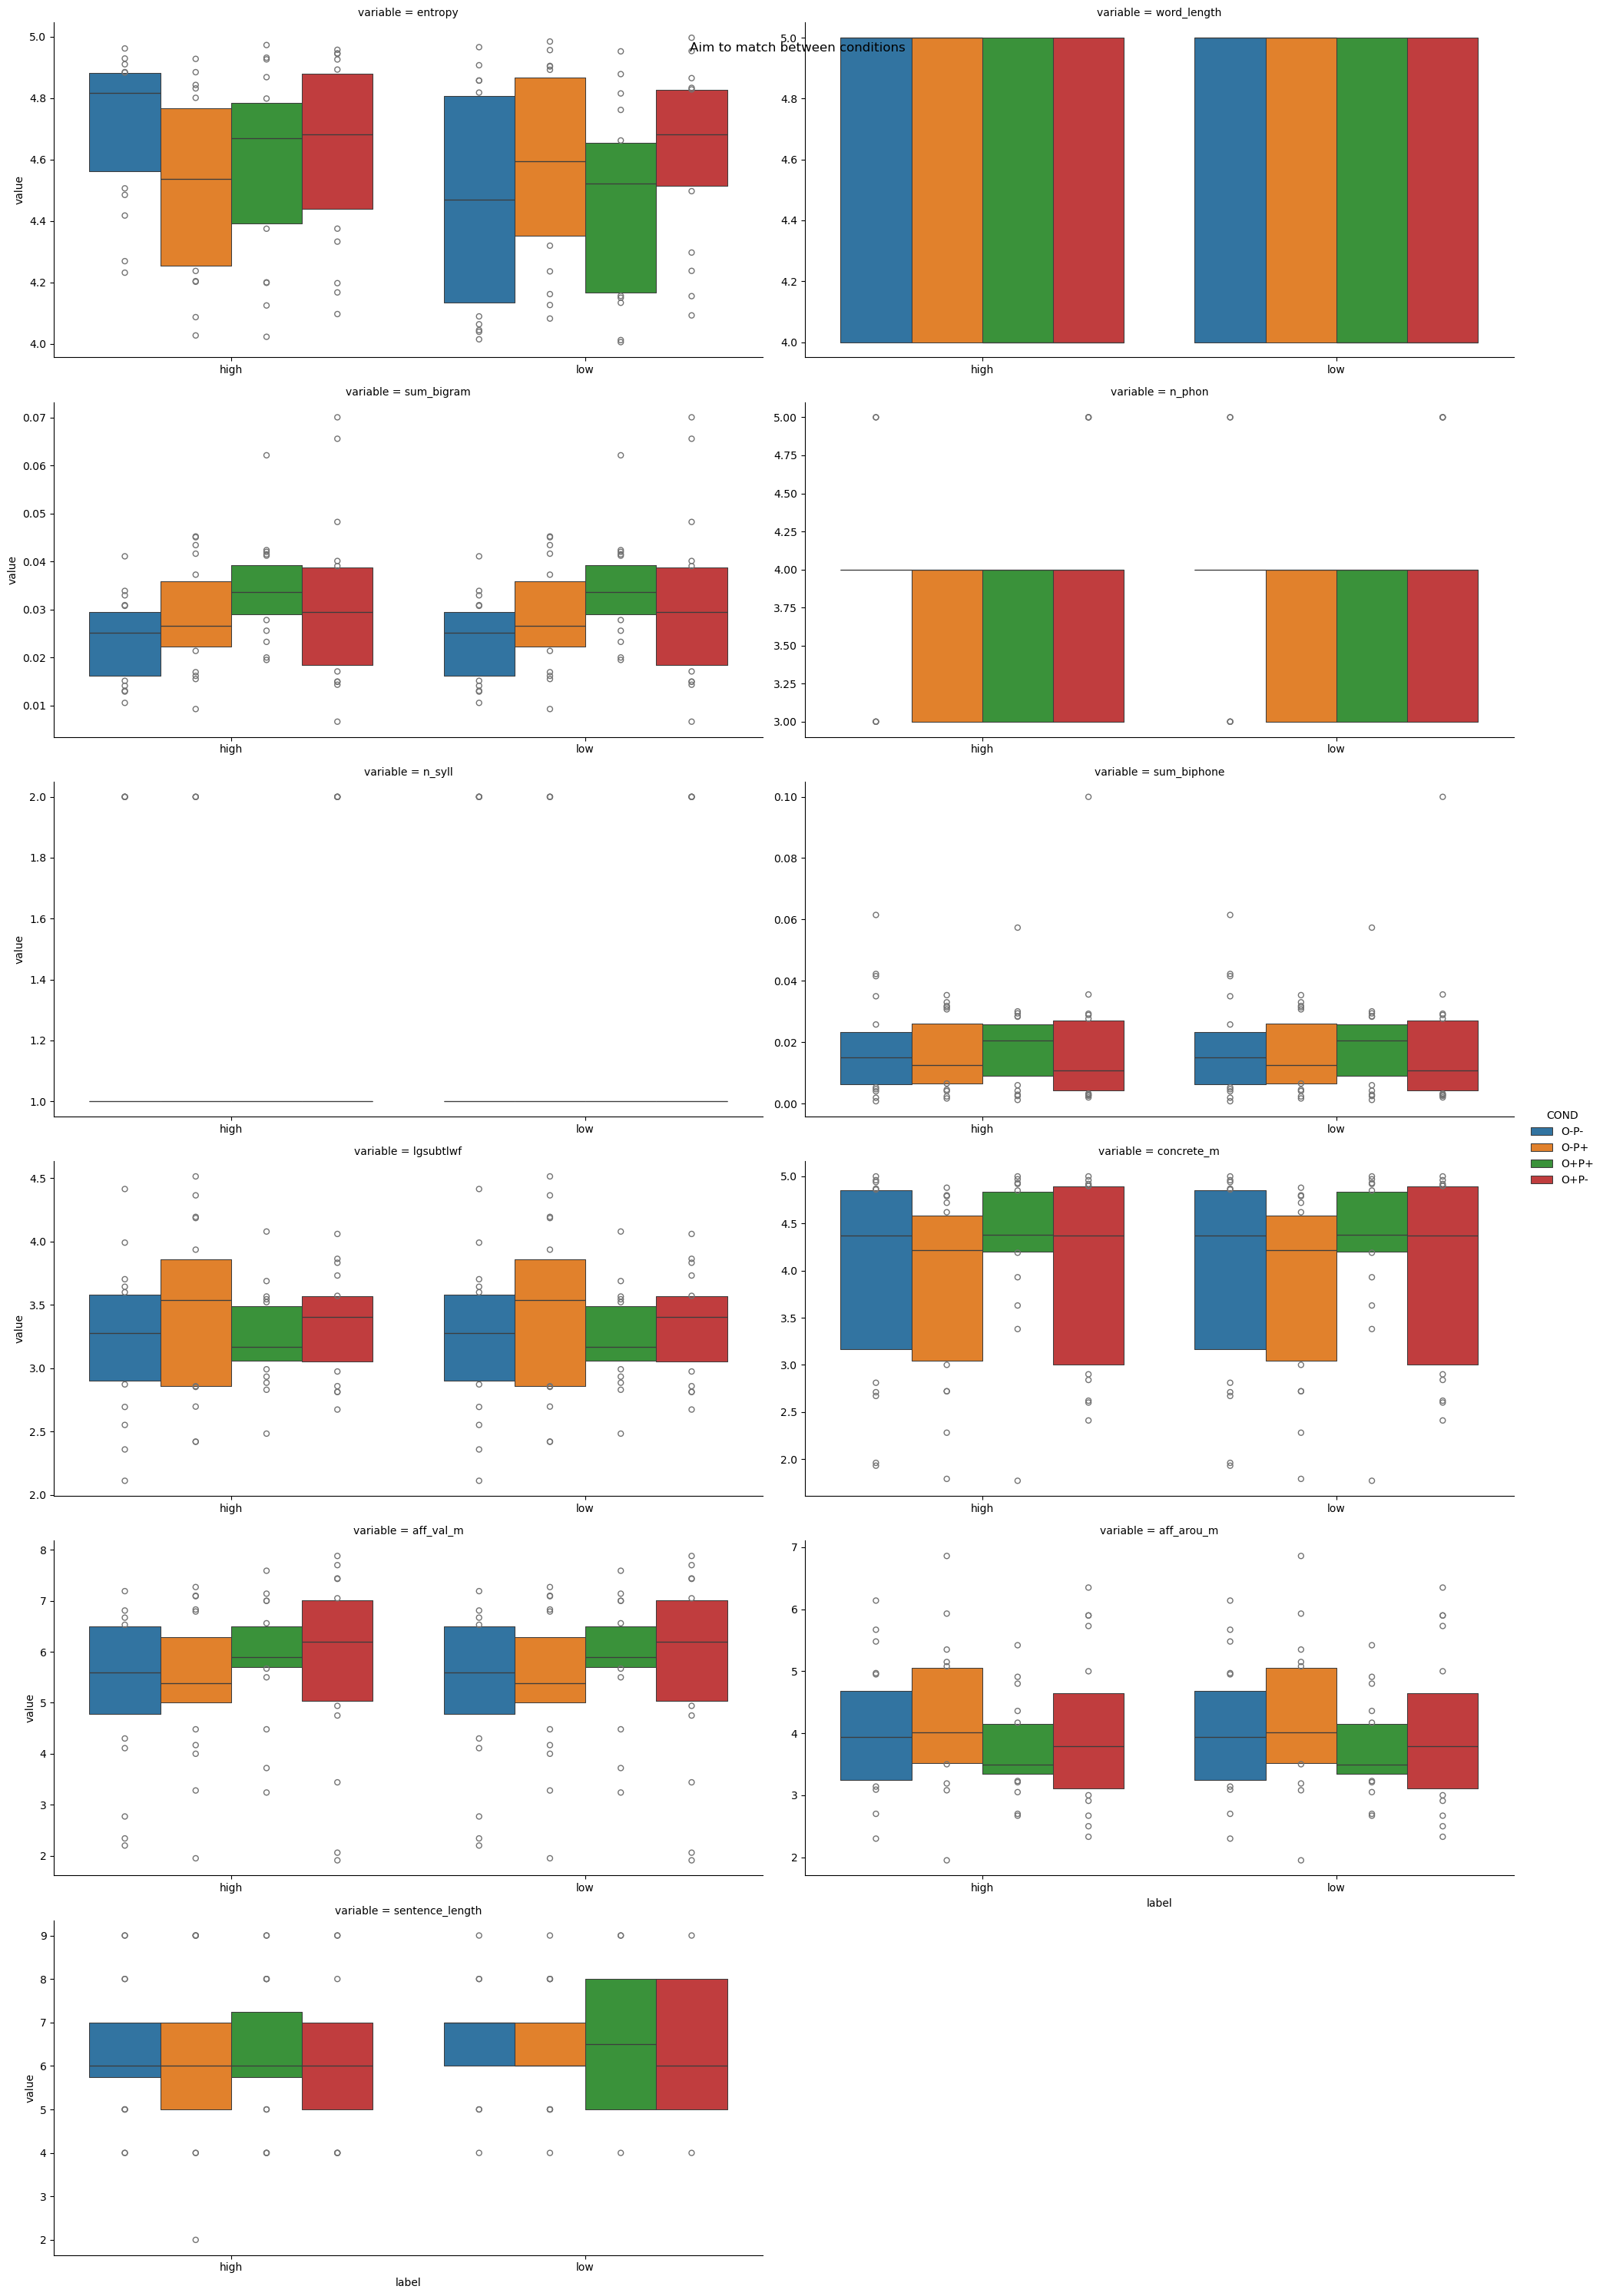

In [20]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(min_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Other stuff')

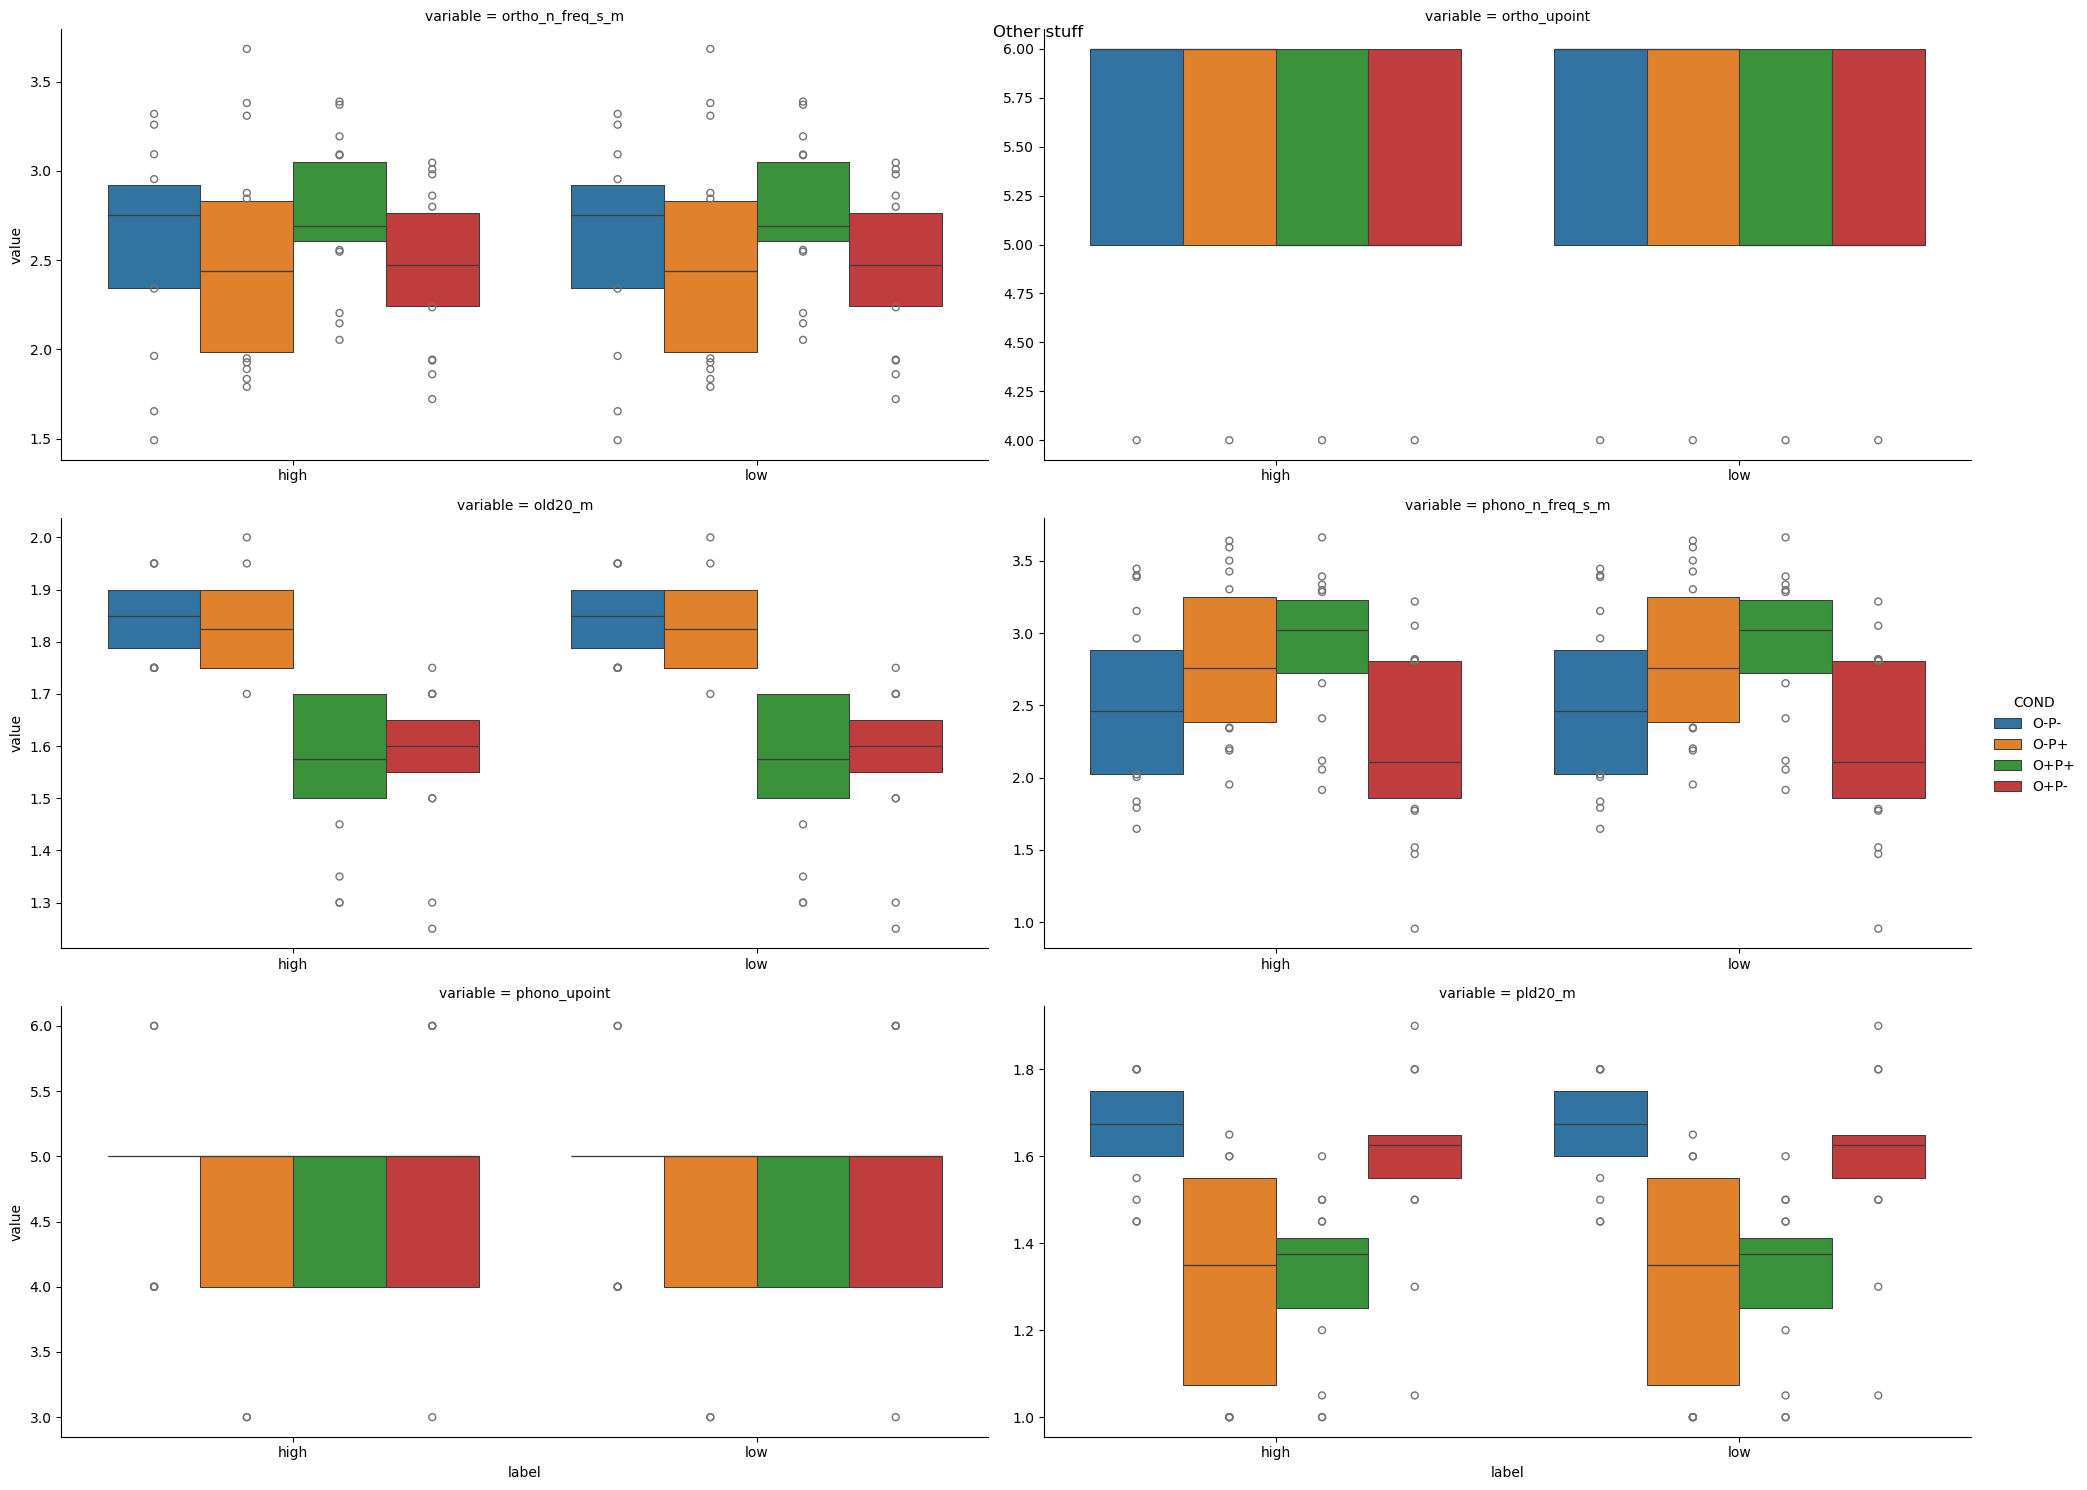

In [21]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(min_variables + max_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


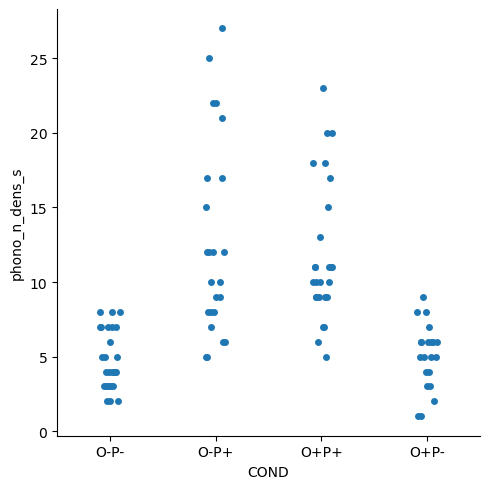

In [27]:
sns.catplot(data=words, x="COND", y="phono_n_dens_s")

In [23]:
words[words.COND == "O-P+"].sort_values("phono_n_dens_s")[["ortho_n_dens_s", "phono_n_dens_s"]]

,ortho_n_dens_s,phono_n_dens_s
word_us,,
frame,1,5
earth,0,5
cause,1,6
drip,3,6
clean,3,7
theme,3,8
waist,1,8
wrong,2,8
crowd,1,9
